# Toxicity - Matteo Mistri and Daniele Papetti
**Tox21 dataset analysis and prediction**

**Dataset input and preprocessing**

In [1]:
import pandas as pd
X_train = pd.read_csv("./dataset/tox21_dense_train.csv")
X_test = pd.read_csv("./dataset/tox21_dense_test.csv")
Y_train = pd.read_csv("./dataset/tox21_labels_train.csv")
Y_test = pd.read_csv("./dataset/tox21_labels_test.csv")

We decide to drop the names of the samples because we are sure that it is an irrelevant feature for the further operations.
We substitute the NaN values in the labels with 0 value since we assume that if the test was not performed, the doctors would have thought that the molecule would have not been involved in that biological pathway. 

In [2]:
# drop first column that contains names
X_train = X_train.drop(X_train.columns[[0]], axis = 1)
X_test = X_test.drop(X_test.columns[[0]], axis = 1)

Y_train = Y_train.drop(Y_train.columns[[0]], axis = 1)
Y_test = Y_test.drop(Y_test.columns[[0]], axis = 1)

In [3]:
# transform NaN in 0 in the labels
Y_train = Y_train.fillna(0)
Y_test = Y_test.fillna(0)

NR.AhR: Counter({0.0: 11079, 1.0: 981})


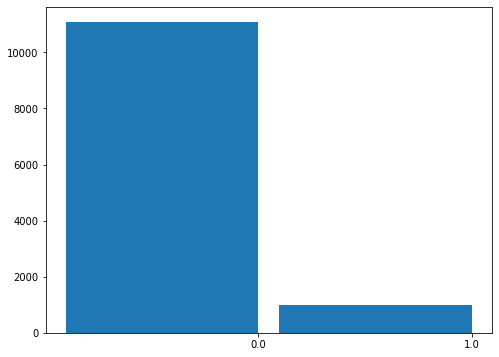

NR.AR: Counter({0.0: 11677, 1.0: 383})


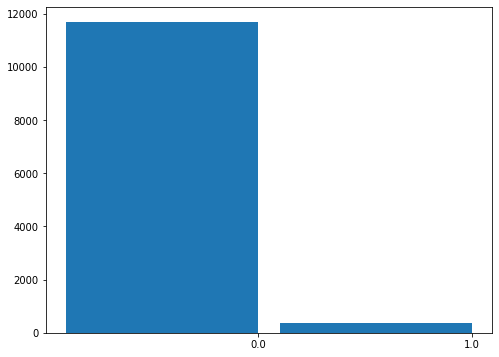

NR.AR.LBD: Counter({0.0: 11753, 1.0: 307})


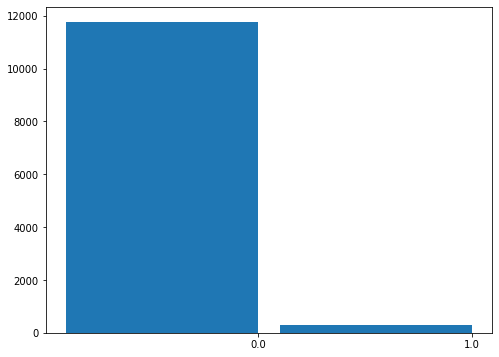

NR.Aromatase: Counter({0.0: 11682, 1.0: 378})


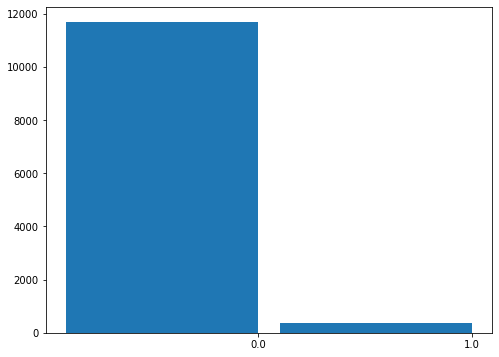

NR.ER: Counter({0.0: 11096, 1.0: 964})


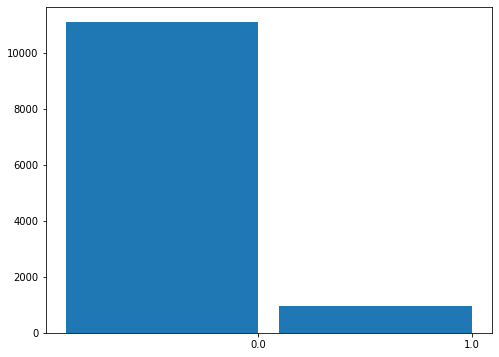

NR.ER.LBD: Counter({0.0: 11604, 1.0: 456})


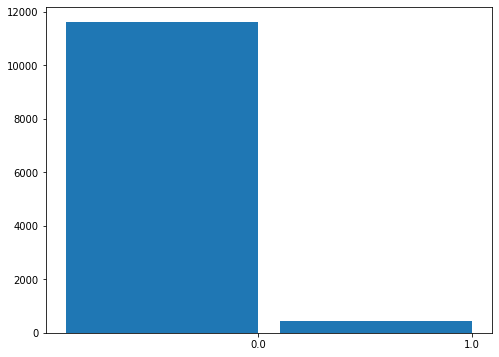

NR.PPAR.gamma: Counter({0.0: 11823, 1.0: 237})


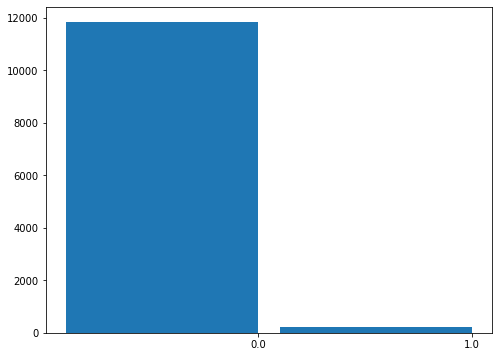

SR.ARE: Counter({0.0: 10914, 1.0: 1146})


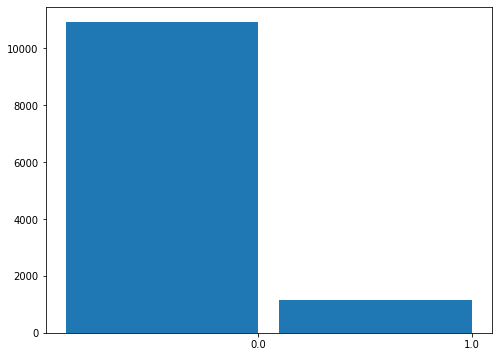

SR.ATAD5: Counter({0.0: 11697, 1.0: 363})


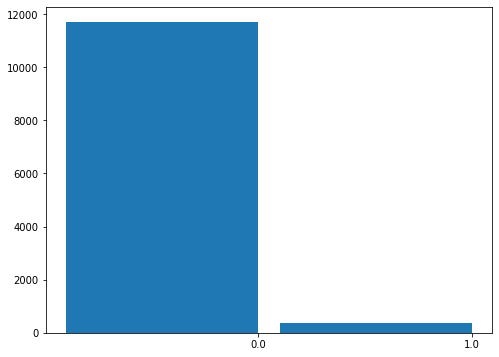

SR.HSE: Counter({0.0: 11622, 1.0: 438})


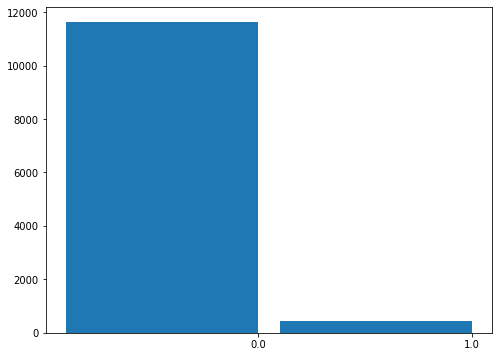

SR.MMP: Counter({0.0: 10880, 1.0: 1180})


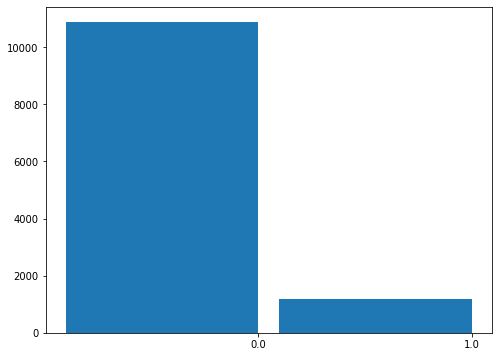

SR.p53: Counter({0.0: 11495, 1.0: 565})


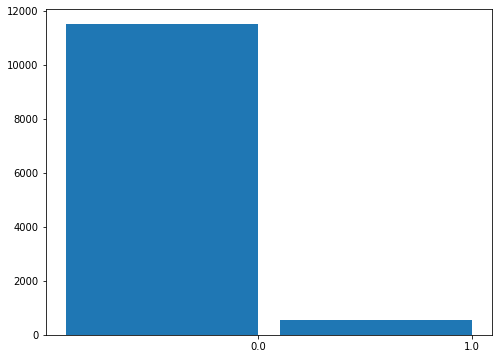

In [8]:
# distribuzione etichette
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

for l in Y_train.columns:
    unique_values_count = Counter(Y_train[l])
    print("{}: {}".format(l, unique_values_count))
    
    labels, values = zip(*unique_values_count.items())
    indexes = np.arange(len(labels))
    width = 0.9
    
    plt.figure(figsize = (8, 6))
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

In [ ]:
# ricerca e gestione outliers (3 * Q3/4-q1/4)

print(X_train.shape)
# remove outliers
outliers = list()
# if we consider feature by feature, we drop all the dataset
# we count how many time a record is considered outlier
for column in X_train.columns:
    mean = X_train[column].mean()
    q1 = X_train[column].quantile(1 / 4)
    q3 = X_train[column].quantile(3 / 4)
    threshold = 3 * (q3 - q1)

    # Indexes of outliers
    outliers.extend(X_train[X_train[column] > mean + threshold].index.values.tolist())      
    outliers.extend(X_train[X_train[column] < mean - threshold].index.values.tolist())

# drop a record if it is considered to be an outlier in more that 1/4 of the features
out_counter = Counter(outliers)
toDrop = [k for k, v in zip(out_counter.keys(), out_counter.values()) if v > 200]

# Delete these row indexes from dataFrame
X_train.drop(toDrop, inplace = True)
Y_train.drop(toDrop, inplace = True)
print(X_train.shape)

In [ ]:
# correlation between labels

# Create correlation matrix
corr_matrix = Y_train.append(Y_test).corr().abs()
# Show matrix
corr_matrix.style.background_gradient(cmap = 'coolwarm').set_precision(2)

In [ ]:
# correlation between features and labels

# Create correlation matrix
corr_matrix = X_train.append(X_test).merge(Y_train.append(Y_test),
                                           right_index = True, left_index = True).corr().abs()
# Print most correlated feature for each class
for label in Y_train.columns:
    # extract correlation column of the considered class
    corr_col = corr_matrix[label]
    # remove the elements whose indes is a label
    cleaned_col = corr_col.drop(Y_train.columns, axis = 0)
    # sort the result
    sorted_col = cleaned_col.sort_values(ascending = False)
    # extract the most correlated features for the considered class
    print("Class {} is mosty correlated with feature {} with a value of {}".format(label, sorted_col.index[0], round(sorted_col[0], 3)))

In [ ]:
# search for missing values in features
print(X_train.isnull().any().any())
print(X_test.isnull().any().any())

In [ ]:
# check if all features are numeric
set(X_train.dtypes.append(X_test.dtypes))

In [ ]:
# normalize features in 0 mean and 1 std
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train.append(X_test).values)
X_train = pd.DataFrame(scaler.transform(X_train.values), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns = X_test.columns)

**Use only one of the following method to reduce number of features**

In [ ]:
# correlation analysis and drop correlated features
# create correlation matrix
corr_matrix = X_train.corr().abs()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
print(len(to_drop))

# drop the features
X_train.drop(X_train[to_drop], axis = 1)
X_test.drop(X_test[to_drop], axis = 1)

In [ ]:
# PCA features reduction
from sklearn.decomposition import PCA

features_limit = 100
columns = ['col' + str(x) for x in range(features_limit)]
PCA_transformer = PCA(n_components = features_limit)
PCA_transformer.fit(X_train.append(X_test).values)
X_train = pd.DataFrame(PCA_transformer.transform(X_train.values), columns = columns)
X_test = pd.DataFrame(PCA_transformer.transform(X_test.values), columns = columns)

In [ ]:
from keras.callbacks import EarlyStopping
import keras.optimizers
from keras.layers import Input, Dense
from keras.models import Model

# AUTOENCODER
# Define early stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', 
                   verbose = 1, patience = 15, min_delta = 0.001,
                   restore_best_weights = True)

encoding_dim1 = int(X_train.shape[1] / 2)
encoding_dim2 = int(encoding_dim1 / 2)
encoding_dim3 = 100
columns = ['col' + str(x) for x in range(encoding_dim3)]

input_layer = Input(shape = (X_train.shape[1],))
# "encoded" is the encoded representation of the input
encoded1 = Dense(encoding_dim1, activation = 'relu')(input_layer)
encoded2 = Dense(encoding_dim2, activation = 'relu')(encoded1)
bottleneck = Dense(encoding_dim3, activation = 'relu')(encoded2)
# "decoded" is the lossy reconstruction of the input
decoded2 = Dense(encoding_dim2, activation = 'relu')(bottleneck)
decoded1 = Dense(encoding_dim1, activation = 'relu')(decoded2)
output_layer = Dense(X_train.shape[1], activation = 'linear')(decoded1)
# this model maps an input to its reconstruction
autoencoder = Model(input_layer, output_layer)
# this model maps an input to its encoded representation
encoder = Model(input_layer, bottleneck)

# compile the model
autoencoder.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
autoencoder.summary()
# fit the autoencoder
autoencoder.fit(X_train.append(X_test).values, X_train.append(X_test).values, 
                validation_split = 0.1, epochs = 300, batch_size = 256, 
                verbose = True, callbacks = [es], use_multiprocessing = True)
# extract representation
X_train = pd.DataFrame(encoder.predict(X_train.values), columns = columns)
X_test = pd.DataFrame(encoder.predict(X_test.values), columns = columns)

In [ ]:
# TODO
# controllare funzione di attivazione autoencoder e relativa loss
# data visualization in 2/3D per vedere se clusterizza (a occhio)

In [ ]:
# Test print
print(X_train)
print(X_test)

print(Y_train)
print(Y_test)

**Classification of the records**

In [ ]:
# TODO
# creazione della DNN cin keras
    # esplorazione preliminare dei parametri (con tutte le features)
# confronto con la medesima DNN delle 3 feature extraction
# AutoML (maybe AutoKeras) su DNN o RandomForest
